In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, select

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [31]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [32]:
# Bonus - reding the table schema
inspector = inspect(engine)
schemas = inspector.get_schema_names()
for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print(table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)

schema: main
measurement
Column: {'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
Column: {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
station
Column: {'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
Column: {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Column: {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
Col

In [33]:
# Save references to each table
Measurement = Base.classes.measurement
Stations = Base.classes.station


In [34]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set
result = session.query(Measurement).with_entities(
        Measurement.id,
        Measurement.station,
        Measurement.date,
        Measurement.prcp,
        Measurement.tobs
        ).order_by(Measurement.date.desc()).limit(1)

format = '%Y-%m-%d'
for row in result:
    end_date =dt.datetime.strptime(row.date, format).date()
    print(row)

start_date = end_date - relativedelta(months=12)
print(f'Analysis Period: {start_date} to {end_date}')


(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)
Analysis Period: 2016-08-23 to 2017-08-23


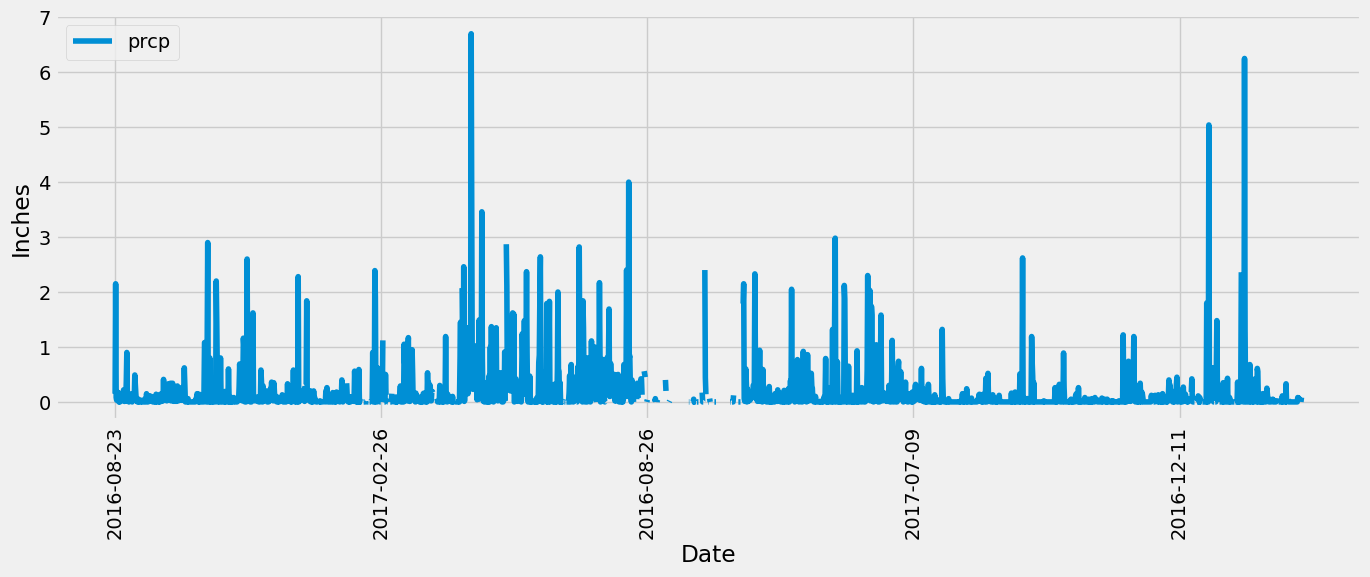

<Figure size 640x480 with 0 Axes>

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
result = session.query(Measurement).filter(Measurement.date >= start_date,Measurement.date <= end_date).with_entities(
        Measurement.date,
        Measurement.station,
        Measurement.prcp,
        Measurement.tobs
        ).order_by(Measurement.station.asc(),Measurement.date.asc())

# Perform a query to retrieve the data and precipitation scores
precpt_data = result.all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precpt_data_df = pd.DataFrame.from_records(
                    precpt_data
                    ,index='date'
                    ,columns=['date','station','prcp','tobs'])

precpt_data_df.head()

# Sort the dataframe by date
#-- already sorted with the query 

# Use Pandas Plotting with Matplotlib to plot the data
precpt_data_df.plot(y='prcp',xlabel='Date',ylabel='Inches',rot=90,figsize= (15, 5))
plt.show()
plt.savefig("Images/Precipitation.png")


In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precpt_data_df.describe()

,prcp,tobs
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


# Exploratory Station Analysis

In [38]:
# Design a query to calculate the total number stations in the dataset
result = session.query(Measurement.station).distinct().count()
print(f'Distinct number of stations:{result}')

Distinct number of stations:9


In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
conn = engine.connect()

result = conn.execute(
        select(Measurement.station, func.count(Measurement.station).label("count"))
        .group_by(Measurement.station))

station_data = result.all()

station_data_df = pd.DataFrame.from_records(
                    station_data
                    ,index='station'
                    ,columns=['station','count'])

station_data_df.sort_values(by='count',ascending=False,inplace=True)
station_data_df.reset_index(inplace=True)
station_data_df.head()


,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [40]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = station_data_df['station'][0]
print(f'Most active station: {active_station}')
active_station_df = precpt_data_df.loc[(precpt_data_df['station'] == active_station )]
active_station_df.describe()

Most active station: USC00519281


,prcp,tobs
count,352.000000,352.000000
mean,0.198949,73.107955
std,0.419182,4.733315
min,0.000000,59.000000
25%,0.000000,70.000000
50%,0.060000,74.000000
75%,0.190000,77.000000
max,2.980000,83.000000


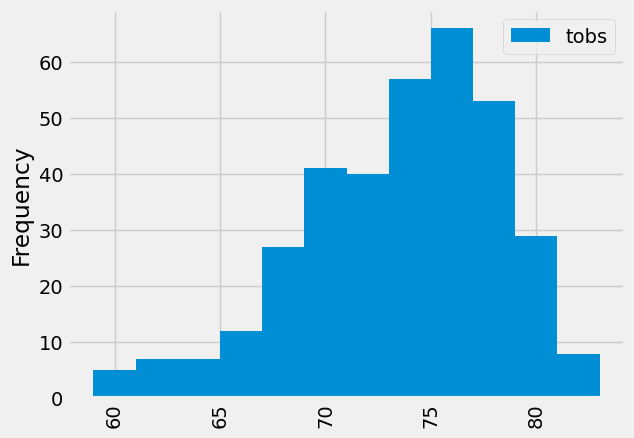

<Figure size 640x480 with 0 Axes>

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(Measurement).filter(Measurement.date >= start_date,
                                                Measurement.date <= end_date,
                                                Measurement.station == active_station).with_entities(
        Measurement.date,
        Measurement.tobs
        ).order_by(Measurement.date.asc())

# Perform a query to retrieve the data and precipitation scores
precpt_station_data = result.all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precpt_stdata_df = pd.DataFrame.from_records(
                    precpt_station_data
                    ,index='date'
                    ,columns=['date','tobs'])

precpt_stdata_df.head()

# Sort the dataframe by date
#-- already sorted with the query 

# Use Pandas Plotting with Matplotlib to plot the data
precpt_stdata_df.plot.hist(xlabel='Temperature',rot=90,bins=12)
plt.show()
plt.savefig("Images/Temperature.png")


# Close session

In [42]:
# Close Session
session.close()